In [1]:
import pandas as pd
import geopandas as gp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
blocks = gp.GeoDataFrame.from_file('./census_blocks/census_blocks.shp')
blocks.head()

,GEOID,NAMELSAD,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,360050001000,Block Group 0,0.0,1035011.0,+40.7981690,-73.8916815,POLYGON ((-73.89772199999999 40.79513800000007...
1,360050001001,Block Group 1,1677210.0,0.0,+40.7911136,-73.8826858,POLYGON ((-73.89265599999999 40.79382400000003...
2,360050002000,Block Group 0,0.0,852046.0,+40.8035344,-73.8606612,POLYGON ((-73.86648399999996 40.80590100000006...
3,360050002003,Block Group 3,168346.0,0.0,+40.8081798,-73.8566782,POLYGON ((-73.85866499999997 40.80683300000004...
4,360050004000,Block Group 0,0.0,685256.0,+40.8034163,-73.8522258,POLYGON ((-73.85525599999994 40.80460800000003...


In [3]:
jobs = pd.read_csv('./nyc_jobs_by_censusblock.csv')
jobs['w_geocode'] = jobs.w_geocode.astype(str)
jobs.rename(columns={'2015_main': 'work_pop'}, inplace=True)
# this is what we'll join on
jobs['stripped_geocode'] = jobs.w_geocode.apply(lambda x: x[:12]).astype(str)

jobs.head()

,w_geocode,2010_main,2010_aux,2010_total,2011_main,2011_aux,2011_total,2012_main,2012_aux,2012_total,...,2013_aux,2013_total,2014_main,2014_aux,2014_total,work_pop,2015_aux,2015_total,w_census_tract_geoid,stripped_geocode
0,360050002002004,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36005000200,360050002002
1,360050002002010,9.0,0.0,9.0,14.0,0.0,14.0,3.0,0.0,3.0,...,0.0,2.0,3.0,0.0,3.0,4.0,0.0,4.0,36005000200,360050002002
2,360050002003000,2.0,0.0,2.0,2.0,0.0,2.0,8.0,0.0,8.0,...,0.0,14.0,5.0,0.0,5.0,8.0,0.0,8.0,36005000200,360050002003
3,360050002003006,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36005000200,360050002003
4,360050002003008,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36005000200,360050002003


In [4]:
pop = pd.read_csv('./ACS_17_5YR_B01003_with_ann.csv', header=1)
pop.rename(columns={'Estimate; Total': 'res_pop'}, inplace=True)

income = pd.read_csv('./ACS_17_5YR_B19013_with_ann.csv', header=1)
income.rename(columns={'Estimate; Median household income in the past 12 months (in 2017 inflation-adjusted dollars)': 'med_inc'}, inplace=True)

In [5]:
blocks['GEOID'] = blocks.GEOID.astype(str)
pop['Id2'] = pop.Id2.astype(str)
income['Id2'] = income.Id2.astype(str)
jobs['w_geocode'] = jobs.w_geocode.astype(str)


joined = blocks.merge(pop[['Id2', 'res_pop']], left_on='GEOID', right_on='Id2', how='outer')
joined = joined.merge(income[['Id2', 'med_inc']], left_on='GEOID', right_on='Id2', how='outer')
joined = joined.merge(jobs[['stripped_geocode', 'work_pop']], left_on='GEOID', right_on='stripped_geocode', how='left')

joined.replace(['-',''],0, inplace=True)
joined.replace('250,000+',250000, inplace=True)
joined.fillna(0, inplace=True)
joined['med_inc'] = joined.med_inc.astype(int)
joined[['GEOID','med_inc', 'res_pop', 'work_pop','geometry']].head()

,GEOID,med_inc,res_pop,work_pop,geometry
0,360050001000,0,0.0,0.0,POLYGON ((-73.89772199999999 40.79513800000007...
1,360050001001,0,7411.0,707.0,POLYGON ((-73.89265599999999 40.79382400000003...
2,360050001001,0,7411.0,706.0,POLYGON ((-73.89265599999999 40.79382400000003...
3,360050002000,0,0.0,0.0,POLYGON ((-73.86648399999996 40.80590100000006...
4,360050002003,71250,961.0,8.0,POLYGON ((-73.85866499999997 40.80683300000004...


In [6]:
# normalize by land area
joined['norm_res_pop'] = joined.apply(lambda x: x.res_pop / x.ALAND if x.ALAND>0 else 0, axis=1)
joined['norm_work_pop'] = joined.apply(lambda x:x.work_pop / x.ALAND if x.ALAND>0 else 0, axis=1)

joined[['GEOID','med_inc', 'res_pop', 'norm_res_pop', 'work_pop', 'norm_work_pop', 'geometry']].head()

,GEOID,med_inc,res_pop,norm_res_pop,work_pop,norm_work_pop,geometry
0,360050001000,0,0.0,0.000000,0.0,0.000000,POLYGON ((-73.89772199999999 40.79513800000007...
1,360050001001,0,7411.0,0.004419,707.0,0.000422,POLYGON ((-73.89265599999999 40.79382400000003...
2,360050001001,0,7411.0,0.004419,706.0,0.000421,POLYGON ((-73.89265599999999 40.79382400000003...
3,360050002000,0,0.0,0.000000,0.0,0.000000,POLYGON ((-73.86648399999996 40.80590100000006...
4,360050002003,71250,961.0,0.005708,8.0,0.000048,POLYGON ((-73.85866499999997 40.80683300000004...


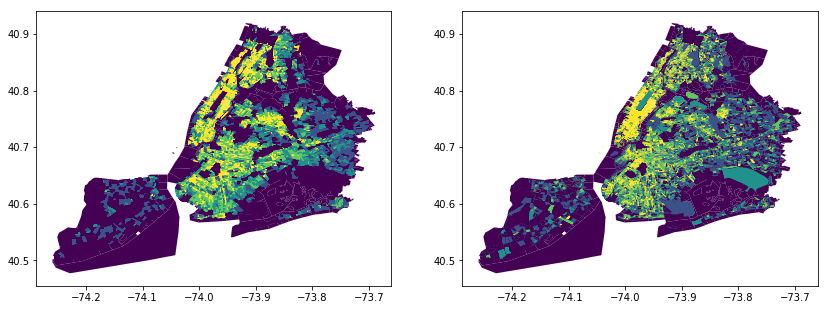

In [28]:
plt.figure(figsize=(14,7))
ax=plt.subplot(121)
joined.plot(column='norm_res_pop', k=5, scheme='Quantiles', edgecolor='none', ax=ax)
ax2=plt.subplot(122)

joined.plot(column='norm_work_pop', k=5, scheme='Quantiles', edgecolor='none', ax=ax2)

## Now to join control variables to intersections

In [34]:
# import intersections and convert both to state plane crs
intersections = gp.GeoDataFrame.from_file('../road_network_data/osm/osm_w_collisions/nodes/nodes.shp').to_crs({'init': 'epsg:2263'})

# get rid of null geometries from census blocks and convert to same crs
joined = joined[joined.type.isin(['Polygon', 'MultiPolygon'])].to_crs({'init': 'epsg:2263'})

In [67]:
# subways will be a point file that we have to find the nearest entrance to each point
subways = gp.GeoDataFrame.from_file('../Subway Entrances/geo_export_7fca276d-b2cc-4f76-8454-596c1e4256d3.shp').to_crs({'init': 'epsg:2263'})

In [71]:
subways['x'] = subways.geometry.x
subways['y'] = subways.geometry.y

#### Now create an Rtree index to make the search faster

In [65]:
from shapely.geometry import Point, box, Polygon
import rtree

In [78]:
# first test with downsampled size
test_intersections = intersections.iloc[:50]

In [87]:
index = rtree.Rtree()
for idx, geometry in enumerate(subways.geometry):
    index.insert(idx, geometry.bounds)

def closest_segment_id_rtree(point, index, subways):
    match = list(index.nearest((point.x, point.y, point.x, point.y)))
    if len(match):
        return subways.loc[match, 'geometry'].distance(point).min()
    else:
        return None
    
def closest_segment_id(point, intersections):
    return intersections.geometry.distance(point).min()

In [83]:
len(subways), len(intersections), len(test_intersections)

(1928, 55161, 50)

In [89]:
%time test_intersections['dist'] = test_intersections.geometry.apply(lambda x: closest_segment_id_rtree(x, index, subways))

Wall time: 457 ms


C:\Users\cyrus\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [96]:
%time intersections['sub_dist'] = intersections.geometry.apply(lambda x: closest_segment_id_rtree(x, index, subways))

Wall time: 2min 36s


In [101]:
intersections.describe()

,Total_Inju,Total_Fata,sub_dist
count,21303.000000,21303.000000,55161.000000
mean,4.171009,0.052434,5005.055171
std,4.958603,0.253455,5653.775126
min,0.000000,0.000000,5.782060
25%,1.000000,0.000000,1080.259265
50%,2.000000,0.000000,2522.071777
75%,5.000000,0.000000,6730.479754
max,81.000000,6.000000,30863.825049


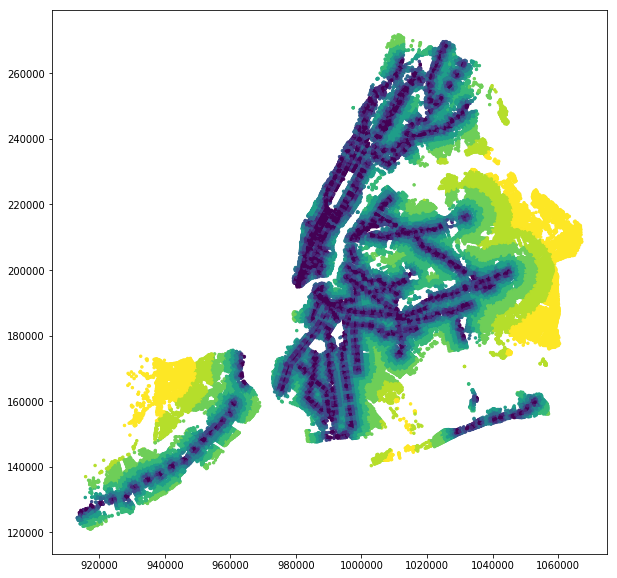

In [102]:
plt.figure(figsize=(10,10))
ax2 = plt.subplot(111)
# ax2.set_xlim(987000, 993000)
# ax2.set_ylim(212000, 218000)
# subways.plot(ax=ax2, markersize=6)
intersections.plot(ax=ax2, markersize=6, column='sub_dist', scheme='Quantiles', k=10)

#### Now join census variables to each intersection

In [118]:
int_buff = intersections.copy()
int_buff['geometry'] = int_buff.geometry.buffer(100)
#use left join so pluto buildings can get joined to more than one street
demo_joined = gp.sjoin(joined, int_buff, how='left')

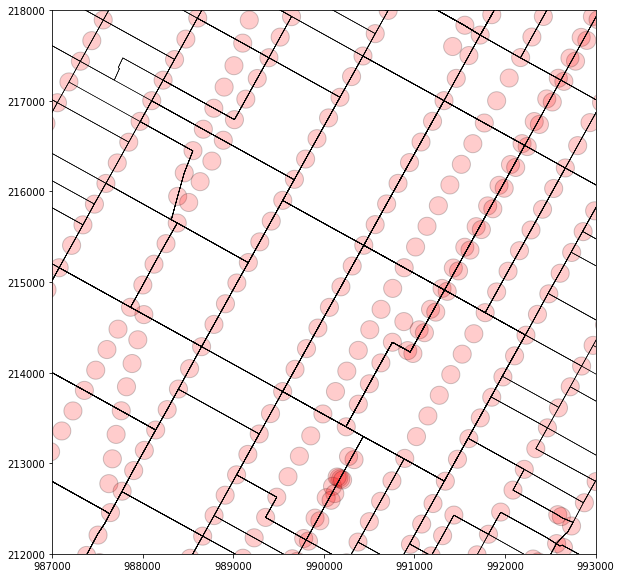

In [114]:
plt.figure(figsize=(10,10))
ax2 = plt.subplot(111)
ax2.set_xlim(987000, 993000)
ax2.set_ylim(212000, 218000)
# subways.plot(ax=ax2, markersize=6)
int_buff.plot(ax=ax2, facecolor='red', edgecolor='black', alpha=0.2)
joined.plot(ax=ax2, edgecolor='black', lw=0.5, facecolor='none')

In [127]:
intersections_joined = intersections.merge(demo_joined.groupby('osmid')[['res_pop', 'med_inc', 'work_pop', 'norm_res_pop', 'norm_work_pop']].mean(),
             left_on='osmid', right_index=True)

In [132]:
intersections_joined = intersections_joined.drop(columns=['highway', 'ref']).fillna(0)

In [133]:
intersections_joined.head()

,osmid,Total_Inju,Total_Fata,geometry,sub_dist,res_pop,med_inc,work_pop,norm_res_pop,norm_work_pop
0,42860546,0.0,0.0,POINT (1000750.795416632 210205.7528114537),1371.429138,7575.000000,137147.000000,156.489796,0.006645,0.000137
1,42467330,2.0,0.0,POINT (1002652.742108569 177974.3482433519),4582.604445,1026.000000,40044.333333,29.166667,0.017451,0.000451
2,42467331,1.0,0.0,POINT (1002921.868557178 177996.4131735155),4416.357204,1088.500000,38804.000000,23.500000,0.020556,0.000376
3,42467333,1.0,0.0,POINT (1003181.00656743 178017.3803186663),4247.996054,1180.250000,55349.250000,22.625000,0.024626,0.000455
4,42467334,23.0,0.0,POINT (1003459.565062104 178040.5515355509),4077.224853,1148.333333,62104.666667,28.000000,0.022878,0.000556


In [135]:
intersections_joined.to_file('../road_network_data/osm/intersections_final/intersections_final')